In [800]:
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
%matplotlib inline
import os
import yaml
from yaml import CLoader as Loader
from glob import glob
import regex as re

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

LOG_PATH = '../logs/'
DL_LOG_PATH = '../dl_logs/logs/'
FINAL_LOG_PATH = '../final_logs/'
MERGED_LOG_PATH = '../dl_logs/merged_logs/'
TEST_LOG_PATH = '../dl_logs/logs_test_dir/'
TO_MERGE_LOG_PATH = '../dl_logs/to_merge/'




In [900]:
def parse_tb_logs(logs_path, metrics_to_plot, threshold=0.75, verbose=False, delete_dir=False):
    values = defaultdict(list)
    if os.path.isdir(join(logs_path, "metrics_synth")):
        metrics_path = join(logs_path, "metrics_synth")
    elif os.path.isdir(join(logs_path, "metrics")):
        metrics_path = join(logs_path, "metrics")
    else:
        print("ERR: logs not found")
        return [], []
        
    list_folds = os.listdir(metrics_path)
    list_folds = [el for el in list_folds if "DS_Store" not in el]
    if len(list_folds) < 1:
        shutil.rmtree(logs_path)
        print(f"{bcolors.FAIL}No folds found: unsuccessful run{bcolors.ENDC}")
        return defaultdict(list), dict()
                              
    for fold_path in list_folds:
        logs_fold_path = join(metrics_path, fold_path)
        match = re.search("fold_([0-9]+)", fold_path)
        fold_nb = int(match.group(1))
        fold_string=f"fold_{fold_nb}"
        if verbose: print(fold_string, end='  ')
    
        event_acc = EventAccumulator(logs_fold_path)
        event_acc.Reload()
        
        #print(event_acc.Tags())
        for tag in metrics_to_plot:
            try:
                _, step_nums, vals = zip(*event_acc.Scalars(tag))
                if verbose:
                    if tag == 'val_acc':
                        print(f"#logged: {len(vals)}, Max_acc: {max(vals):.3}", end=" ")
                    if tag == 'val_step':
                        print(f"Max_step: {int(max(vals))}", end=" ")
                if len(vals) < 2 or ('acc' in tag and max(vals) < threshold):
                    print(f"{bcolors.FAIL}unsuccessful run{bcolors.ENDC}")
                    if delete_dir: shutil.rmtree(logs_path)
                    return defaultdict(list), dict()
                values[tag].append(list(np.around(vals, 4)))
                values[f'{tag}_step'].append(list(step_nums))
                values['fold_nb'].append(fold_nb)
            except:
                print(f"{bcolors.WARNING}warning: {tag} not in logs{bcolors.ENDC}", end=" ")
                if delete_dir: 
                    shutil.rmtree(logs_path)
                    print()
                    return defaultdict(list), dict()
                pass
        if verbose: print()
    print(f'#folds: {len(list_folds)}')
        
    with open(join(logs_fold_path, 'hparams.yaml')) as file:
        hparams_dict = yaml.load(file, Loader=Loader)
    
    fold_ckpts = [y for x in os.walk(logs_path) for y in glob(os.path.join(x[0], '*.ckpt'))]
    hparams_dict.pop('args', None)
        
    return values, hparams_dict

def interpolate_values(metrics_to_plot, values, x_values, tot_num_values=100):
    interp_values = defaultdict(list)

    for metric_name in metrics_to_plot:
        val_cond = 'val' in metric_name
        max_epochs_real = max([max(el) for el in x_values])
        x = np.linspace(0, max_epochs_real, num=tot_num_values)
        temp_lists=[]
        
        for steps, vals in zip(x_values, values[metric_name]):
            temp_lists.append(np.interp(x, steps, vals))
        
        x_values_flat = [item for x_val in x_values for item in x_val]
        metric_values_flat = [item for val in values[metric_name] for item in val]
        
        interp_values[f'{metric_name}_interp_steps'] = list(x)
        interp_values[f'{metric_name}_interp_mean'] = np.mean(temp_lists, axis=0)
        var1 = np.var(temp_lists, axis=0)
        var2 = np.sum((np.array([el - np.mean(temp_lists, axis=0) for el in temp_lists]))**2, axis=0) / len(temp_lists)
        interp_values[f'{metric_name}_interp_var'] = var2
    
    return interp_values, (x_values_flat, metric_values_flat)

def plot_metrics(metrics_to_plot, interp_values_df, ax, label, epochs_values=None, color=None, values_flat=None, plot_points=False):
    
    for i, metric_name in enumerate(metrics_to_plot):
        if epochs_values == None:
            epochs = interp_values_df[f'{metric_name}_interp_steps']
        else:
            epochs = np.linspace(0, max([max(el) for el in epochs_values]), interp_values_df.shape[0])
        
        mean_val = interp_values_df[f'{metric_name}_interp_mean']
        var_val = interp_values_df[f'{metric_name}_interp_var']
        
        cutoff = [i for i, n in enumerate(mean_val) if n > 0.99]
        if len(cutoff) < 50:
            cutoff = -1
        else:
            cutoff=cutoff[50]
            
        epochs, mean_val,var_val = epochs[:cutoff], mean_val[:cutoff],var_val[:cutoff]
        
        if plot_points and 'acc' in metric_name and values_flat:
            ax[i].scatter(values_flat[0], values_flat[1], color=color, marker='o', s=3, alpha=0.25)
        ax[i].plot(epochs, mean_val, label=label, color=color) #, yerr=var_val) 
        ax[i].fill_between(epochs, mean_val-var_val, mean_val+var_val, alpha=0.2, facecolor='k')
        ax[i].set_title(metric_name)
        ax[i].set_xlabel("steps")
        if 'acc' in metric_name:
            ax[i].plot(epochs, np.ones(len(epochs)) * 0.95, '--k', linewidth=1, alpha=0.6)
        
    return ax

def create_run_dict(hparams_dict, metric_values, ckpt_name):
    hparams_dict['name'] = ckpt_name
    hparams_dict['eval_steps'] = []
    hparams_dict['best_score'] = max([max(el) for el in metric_values['val_acc']])
    return hparams_dict
        
        
def parse_regex(ckpt_name):
    match=re.search(re.compile("_d([0-9]+)"), ckpt_name)
    depth=int(match.group(1)) 
    match=re.search(re.compile("_b([0-9]+)"), ckpt_name)
    b_len=int(match.group(1))
    match=re.search(re.compile("_rep([0-9]+)"), ckpt_name)
    repetition_nb=int(match.group(1))

    patt = "(?:merged_)*([0-9]+)_[0-9]+_[0-9]+_[a-z]+_((?:um|rand)_b[0-9]+_d[0-9]+_h[0-9]+_lr[0-9]+)"
    matched = re.match(patt, ckpt_name)
    hash1 = matched.group(2) # create hash
    job_id = matched.group(2) # create hash

    return depth, b_len, repetition_nb, hash1, job_id

def plot_agg_metrics(metrics_to_plot, logs_paths, checkpoints, 
                     name: str=None, tot_num_values=200, 
                     plot_legend=0, val_epochs_logged=False, threshold=0.75, 
                     color_patt=None, verbose=False, delete_dir=False):
    highscore_table = []
    f,a = plt.subplots(1, len(metrics_to_plot)-1)
    f.set_size_inches(24,8)
    f.tight_layout()
    plt.ylim(0,1.1)
    is_labeled = np.zeros(10)
    tot_len_ckpt = len(logs_paths)
    all_metric_values_dict = dict()
    all_hparams_dict = dict()
        
    for i, (logs_path, ckpt_name) in enumerate(zip(logs_paths, checkpoints)):
        print(ckpt_name)

        depth, b_len, repetition_nb, hash1, job_id = parse_regex(ckpt_name)

        metric_values, hparams_dict = parse_tb_logs(logs_path, metrics_to_plot, threshold=threshold, 
                                                    verbose=verbose, delete_dir=delete_dir)  
        hparams_dict['name'] = ckpt_name
        hparams_dict['job_id'] = job_id
        
        if hash1 in all_metric_values_dict.keys() and np.isclose(all_hparams_dict[hash1]['job_id'], job_id, atol=4):
            #merge...
            for key1 in all_metric_values_dict[hash1].keys():
                all_metric_values_dict[hash1][key1].append(metric_values[key1])
            
            list_steps = all_metric_values_dict[hash1]['val_step']
            for key, metric_list in all_metric_values_dict[hash1]:   
                all_metric_values_dict[hash1][key1] = [x for _, x in sorted(zip(list_steps, metric_list))]
        else:
            all_metric_values_dict[hash1] = metric_values
        all_hparams_dict[hash1] = hparams_dict
            
        #highscore_table.append(create_run_dict(hparams_dict, metric_values, ckpt_name))   

    for i, key1 in enumerate(all_metric_values_dict.keys()):
        metric_values, hparams_dict = all_metric_values_dict[key1], all_hparams_dict[key1]
    
        interp_values, values_flat = interpolate_values(metrics_to_plot=['val_loss', 'val_acc'], 
                                           values=metric_values, x_values=metric_values['val_step'],
                                           tot_num_values=tot_num_values)
        interp_values_df = pd.DataFrame(interp_values)
        
        label_pos = [i for i in range(len(ckpt_name)) if ckpt_name.startswith('_', i)]
        
        if color_patt == None:
            cmap = plt.get_cmap(cm_names[np.log10(b_len)])
            lightness = repetition_nb / 100
            color = cmap(lightness)
        elif color_patt == 'discrete':
            #color = cmap(i/8) #tot_len_ckpt)
            color = None
            
        label = None
        if plot_legend == 1:
            label = str(ckpt_name[label_pos[1]+1:label_pos[2]])+str(ckpt_name[label_pos[3]+1:])
        if plot_legend == 2:
            if not is_labeled[depth-1]: #and lightness > 0.3:
                label = str(f"depth={depth}")
                is_labeled[depth-1] = True
        plot_metrics(metrics_to_plot=['val_loss', 'val_acc'], interp_values_df=interp_values_df, 
                     ax=a, label=label, epochs_values=None, color=color, values_flat=values_flat)
    if plot_legend > 0:
        for ax in a:
            ax.legend()        
        
    f.subplots_adjust(hspace=0.2)
    if name:
        f.savefig(f'../plots/{name}.jpg', dpi=300)
    
    return highscore_table


def plot_runs_w_regex(re_patt_to_search, threshold, log_path=LOG_PATH, verbose=False, delete_dir=False):
    plot_name=f"plot_>{threshold}_{re_patt_to_search}"
    all_ckpt_dirs = os.listdir(log_path)
    all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
    all_ckpt_dirs = [el for el in all_ckpt_dirs if re.search(re_patt_to_search, el)]
    
    all_ckpt_dirs = sorted(all_ckpt_dirs, key=lambda d: int(re.search('b([0-9]*)', d).group(1)), reverse=False)
    all_ckpt_dirs = sorted(all_ckpt_dirs, key=lambda d: float(re.search('lr([0-9.]*)', d).group(1)), reverse=True)

    logs_paths = [join(log_path, ckpt) for ckpt in all_ckpt_dirs]
    print(f"{bcolors.OKGREEN}#logged paths : {len(logs_paths)} {bcolors.ENDC}")
    highscore_table = plot_agg_metrics(metrics_to_plot, logs_paths, all_ckpt_dirs,
                                                       name=plot_name, tot_num_values=10000, plot_legend=1,
                                                       threshold=threshold, color_patt='discrete', verbose=verbose, 
                                                       delete_dir=delete_dir)
    plt.show()

In [836]:
#metrics_to_plot = ['val_loss', 'val_acc', 'val_ap', 'val_auroc', 
#                   'train_loss_epoch', 'train_acc', 'train_ap']

cm_names = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds']
metrics_to_plot = ['val_loss', 'val_acc', 'val_step']


# Filtered graphs

#logged paths : 5 
merged_27278478_3105_2345_synth_um_b0_d7_h250_lr2.0_rep0
fold_4  #logged: 1537, Max_acc: 1.0 Max_step: 121542 
fold_3  #logged: 1197, Max_acc: 1.0 Max_step: 94852 
fold_2  #logged: 1593, Max_acc: 1.0 Max_step: 126653 
fold_5  #logged: 1422, Max_acc: 1.0 Max_step: 112345 
fold_44  #logged: 912, Max_acc: 1.0 Max_step: 76322 
fold_43  #logged: 932, Max_acc: 1.0 Max_step: 76583 
fold_26  #logged: 924, Max_acc: 1.0 Max_step: 75910 
fold_19  #logged: 954, Max_acc: 1.0 Max_step: 78789 
fold_21  #logged: 1018, Max_acc: 1.0 Max_step: 82844 
fold_17  #logged: 1017, Max_acc: 1.0 Max_step: 84044 
fold_28  #logged: 938, Max_acc: 1.0 Max_step: 76744 
fold_10  #logged: 873, Max_acc: 1.0 Max_step: 72308 
fold_42  #logged: 917, Max_acc: 1.0 Max_step: 75827 
fold_45  #logged: 926, Max_acc: 1.0 Max_step: 76279 
fold_11  #logged: 900, Max_acc: 1.0 Max_step: 74512 
fold_16  #logged: 945, Max_acc: 1.0 Max_step: 78404 
fold_29  #logged: 929, Max_acc: 1.0 Max_step: 76396 
fold_20  #logged: 

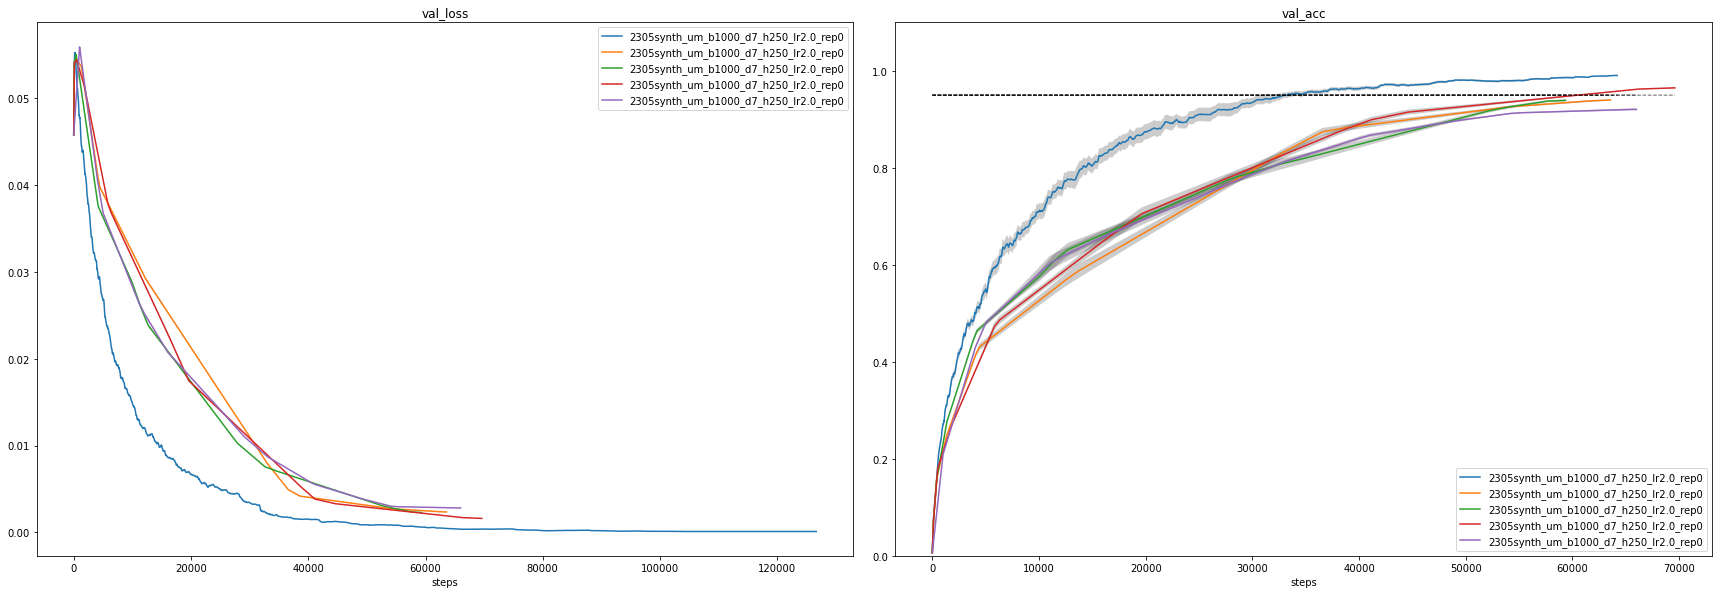

In [901]:
patts_to_search2 = ["um_b0_d5", "um_b0_d6", "um_b0_d7", "um_b0_d8", "um_b0_d9", "um_b0_d10", 
                    "rand_b0_d5", "rand_b0_d6", "rand_b0_d7", "rand_b0_d8", "rand_b0_d9", "rand_b0_d10"]

patt = ["um_b0_d5_h30", 'um_b1_d5_h30', 'um_b10_d5_h30', 'um_b100_d5_h30', 'um_b1000_d5_h30', 'd5_h30',
                    "um_b0_d6_h30", 'um_b1_d6_h30', 'um_b10_d6_h30', 'um_b100_d6_h30', 'um_b1000_d6_h30']

patts_to_search2 = ['d5_h30_lr2','d6_h30_lr2', 'd7_h250_lr2', 'd8_h500_lr5', "d9_h500_lr5", "d10"]
patts_to_search2 = ["d7_h250_lr2"]

for patt in patts_to_search2: plot_runs_w_regex(patt, 0.811, MERGED_LOG_PATH, verbose=True, delete_dir=False)

# Log folds merger

In [904]:
import shutil
import itertools
from collections import Counter
from more_itertools import locate

def get_len_vals(dest_path):
    event_acc_old = EventAccumulator(dest_path)
    event_acc_old.Reload()
    try:
        _, step_nums, vals = zip(*event_acc.Scalars('val_acc'))
        return len(vals)
    except:
        return 0
    
def rename_w_rep(log_path):
    all_ckpt_dirs=os.listdir(log_path)
    all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
    for log_dir in all_ckpt_dirs:
        if not 'rep' in log_dir:
            fold_x = os.listdir(join(log_path,log_dir,'metrics'))
            fold_x = [el for el in fold_x if 'fold' in el]
            fold_nb = int(re.match('fold_([0-9]+)', fold_x).group(1))
            os.rename(join(log_path,log_dir), join(log_path,f'{log_dir}_rep{fold_nb}'))
            
def get_folds_to_merge(log_path, all_ckpt_dirs):
    
    patt = "(?:merged_)*([0-9]+)_[0-9]+_[0-9]+_[a-z]+_((?:um|rand)_b[0-9]+_d[0-9]+_h[0-9]+_lr[0-9]+)"
    matched = [re.match(patt, el) for el in all_ckpt_dirs]
    hashes = [el.group(2) for el in matched] # create hashes
    counts = Counter(hashes)
    dup_hashes = [i for i in counts.keys() if counts[i] > 1] # keep only ckpts w duplicates
    dup_hashes = np.array(dup_hashes)
    print(dup_hashes)
    folds_to_merge = [all_ckpt_dirs[list(locate(hashes, lambda x: x == hash1))] for hash1 in dup_hashes] # get the actual paths
    print(folds_to_merge)
    folds_to_merge = [[join(log_path, fold, 'metrics') for fold in folds] for folds in folds_to_merge]
    return folds_to_merge
    
def merge_folds(log_path=LOG_PATH):
    rename_w_rep(log_path)
    all_ckpt_dirs = os.listdir(log_path)
    all_ckpt_dirs = np.array([el for el in all_ckpt_dirs if "DS_Store" not in el])
    
    #all_ckpt_dirs = [el for el in all_ckpt_dirs if re.search(re_patt_to_search, el)]
    folds_to_merge = get_folds_to_merge(log_path, all_ckpt_dirs)
    
    for folds in folds_to_merge: 
        for i, fold in enumerate(folds): 
            assert(os.path.isdir(fold))
            folds_x = os.listdir(fold)
            if len(folds_x) < 1:
                shutil.rmtree(fold)
                del folds[i]
            ds_store=join(fold, '.DS_Store')
            if os.path.isdir(ds_store): os.remove(ds_store)
    
    for folds in folds_to_merge:
        # find smallest fold nb
        prev_fold_nb = 100
        for i, fold in enumerate(folds):
            print(fold)
            min_fold_nb = int(re.match('[a-z0-9./_]*rep([0-9]+)', fold).group(1))
            folds_x = os.listdir(fold)
            folds_x = [el for el in folds_x if "DS_Store" not in el]
            merged_folds_nb = [int(re.match('fold_([0-9]+)', fold_x).group(1)) for fold_x in folds_x]
            if min_fold_nb < prev_fold_nb or ('merged' in fold):
                prev_fold_nb = min_fold_nb
                prev_fold_idx = i
                dest_path = fold
                merged_folds_nb = merged_folds_nb
                if ('merged' in fold): break
        
        if not 'merged' in dest_path:
            dest_path_idx = [i for i, letter in enumerate(dest_path) if letter == '/']
            dest_path_pre = dest_path[:dest_path_idx[2]]
            dest_path_ckpt = dest_path[dest_path_idx[2]+1:dest_path_idx[3]]
            dest_fold_path = dest_path[:dest_path_idx[-1]]
            new_dest_ckpt = f'merged_{dest_path_ckpt}'
            new_dest_fold_path = join(dest_path_pre, new_dest_ckpt)
            os.rename(dest_fold_path, new_dest_fold_path)
            del folds[prev_fold_idx]
            dest_path = join(new_dest_fold_path, 'metrics')
        
        for fold in folds:
            list_folds = os.listdir(fold)
            list_folds = [el for el in list_folds if "DS_Store" not in el]
            foldnb2 = int(re.match('fold_([0-9]+)', list_folds[0]).group(1))
            source_path = join(fold, list_folds[0])
            #print('dest_fold_nb', dest_path, merged_folds_nb, 'foldnb2', source_path, foldnb2)
            merged_folds_nb.append(foldnb2)
            do_move=True

            # Check if file already exists
            hyp_dest_path = join(dest_path, f'fold_{foldnb2}')
            print(hyp_dest_path, source_path)
            if os.path.isdir(hyp_dest_path):
                print(hyp_dest_path,'exists in the destination path!')

                if get_len_vals(hyp_dest_path) < get_len_vals(source_path):
                    shutil.rmtree(hyp_dest_path)
                    print("rem")
                else:
                    do_move=False

            if do_move:
                shutil.move(source_path, dest_path)

            folder = source_path[:source_path[:source_path.rfind('/')].rfind('/')]
            #print("TO remove", folder)
            shutil.rmtree(folder)
                

#27147228_2504_1617_synth_um_b0_d8_h300_lr5
!cd $DL_LOG_PATH
!find . -name '.DS_Store' -type f -delete
!echo DONE
merge_folds(TO_MERGE_LOG_PATH)


    

DONE
['um_b1000_d7_h250_lr2']


TypeError: list indices must be integers or slices, not list

In [765]:
def clean_folds(log_path=LOG_PATH):    
    all_ckpt_dirs = os.listdir(log_path)
    all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
    all_ckpt_dirs = [join(log_path, ckpt_path, 'metrics') for ckpt_path in all_ckpt_dirs]
    
    for ckpt in all_ckpt_dirs:
        folds = os.listdir(ckpt)
        for el in folds:
            if 'fold' not in el:
                el = join(ckpt, el)
                if os.path.isdir(el):
                    shutil.rmtree(el)
                else:
                    os.remove(el)
                
#clean_folds(log_path=DL_LOG_PATH)    

In [845]:
a = [0,1,2,5,16,100,200,300,400]

diff = [a[i] - a[i-1] for i in range(1,len(a))]
print(diff)
np.argmax(diff)

[1, 1, 3, 11, 84, 100, 100, 100]


5